In [1]:
import pandas as pd
import geopandas as gpd
import shapely
from shapely.wkt import loads
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
merged = gpd.read_parquet('/Users/lisawink/Documents/paper1/data/freiburg_2D3D_stats.parquet')

In [3]:
list(merged.isnull().sum())

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 7,
 11,
 11,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 2,
 0,
 2,
 0,
 2,
 0,
 0,
 0,
 2,
 0,
 0,
 0]

In [4]:
merged

,index,oid,aktualit,gebnutzbez,funktion,fktkurz,geometry_x,ssbCCo,ssbCor,ssbSqu,...,girth_index_3d,dispersion_index_2d,dispersion_index_3d,range_index_2d,range_index_3d,roughness_index_2d,roughness_index_3d,shared_walls_area,closest_distance,geometry
0,17,DEBWL0010007TAh1,2012-11-14,Gebaeude,"Gaststätte, Restaurant",31001_2081,"POLYGON ((4162539.033 2757993.832, 4162544.17 ...",0.595764,4,0.068855,...,0.655995,0.849581,0.844430,0.772157,0.692882,0.854465,0.883155,122.435073,-0.000000,"POLYGON ((4162539.033 2757993.832, 4162544.17 ..."
1,20,DEBWL0010007TAh6,2012-11-14,Gebaeude,Betriebsgebäude,31001_2112,"POLYGON ((4163308.005 2757360.171, 4163304.918...",0.566846,15,4.680909,...,0.406631,0.828596,0.717658,0.753334,0.581213,0.581687,1.043476,0.000000,437.669539,"POLYGON ((4163308.005 2757360.171, 4163304.918..."
2,21,DEBWL0010007TAh7,2012-11-14,Gebaeude,"Hotel, Motel, Pension",31001_2071,"POLYGON ((4163712.366 2757615.149, 4163713.637...",0.115547,21,6.041264,...,0.492272,0.469581,0.464490,0.339722,0.291889,0.542178,2.107921,0.000000,130.081929,"POLYGON ((4163712.366 2757615.149, 4163713.637..."
3,23,DEBWL0010007TA00,2012-11-14,Gebaeude,Wohnhaus,31001_1010,"POLYGON ((4160209.982 2765518.528, 4160210.032...",0.471293,14,2.375291,...,0.629824,0.783923,0.788211,0.686164,0.638603,0.664181,0.950187,305.470571,0.125000,"POLYGON ((4160209.982 2765518.528, 4160210.032..."
4,24,DEBWL0010007TA01,2019-12-06,Gebaeude,Umformer,31001_2523,"POLYGON ((4159965.118 2765576.552, 4159965.535...",0.559867,4,0.535868,...,0.552933,0.810153,0.783347,0.748626,0.657029,0.902548,1.020526,27.083257,-0.000000,"POLYGON ((4159965.118 2765576.552, 4159965.535..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35827,40805,DEBWL0010007TymG,2024-04-12,Gebaeude,Wohnhaus,31001_1010,"POLYGON ((4158716.693 2769150.428, 4158716.946...",0.547784,12,1.066791,...,0.640757,0.850466,0.835708,0.703143,0.638176,0.703696,0.840638,118.063506,-0.000000,"POLYGON ((4157011.07 2766388.481, 4157018.893 ..."
35828,40806,DEBWL0010007TymI,2024-04-12,Gebaeude,Wohn- und Geschäftsgebäude,31001_1123,"POLYGON ((4158718.326 2769132.665, 4158725.299...",0.543621,8,0.168153,...,0.496496,0.874225,0.815201,0.730035,0.630229,0.726188,0.853659,62.850276,-0.000000,"POLYGON ((4161186.79 2769023.492, 4161186.546 ..."
35829,40810,DEBWL0010007Tyke,2024-04-16,Gebaeude,"Treibhaus, Gewächshaus",31001_2740,"POLYGON ((4158637.012 2769501.823, 4158639.824...",0.611308,4,0.986367,...,0.375154,0.885445,0.773145,0.788602,0.653306,0.926949,1.073592,0.000000,3.972566,"POLYGON ((4161189.914 2769026.578, 4161190.684..."
35830,40811,DEBWL0010007Tykc,2024-04-16,Gebaeude,Wohnhaus,31001_1010,"POLYGON ((4158626.745 2769530.358, 4158644.786...",0.213097,8,0.329983,...,0.336606,0.539112,0.504131,0.462311,0.347516,0.564977,2.207258,83.851076,0.007000,"POLYGON ((4161182.973 2769124.812, 4161189.743..."


In [5]:
merged = merged.dropna()

remove stbCeA (cell alignment not relevant)  , libNCo (neighbouring courtyards not relavant and too complex)
only keep non-collinear parameters

In [18]:
# Select the relevant variables and standardize them
variables = merged[[ 'ssbSqu',
       'sdbAre', 'sdbPer','ssbElo',
       'stbOri', 'mtbSWR', 'mtbNDi',
       'stbSAl','actual_volume',
       'fractality_2d',
       'roughness_index_2d']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(variables)

In [19]:
# Perform PCA
pca = PCA()
pca.fit(X_scaled)

PCA()

In [20]:
# Get the loadings
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(len(pca.components_))], index=variables.columns)
print(loadings)

                         PC1       PC2       PC3       PC4       PC5  \
ssbSqu              0.105140 -0.017677 -0.298889 -0.688864 -0.198234   
sdbAre              0.461573  0.195757  0.105799  0.171464  0.061066   
sdbPer              0.508692  0.115611  0.010818  0.014453 -0.000140   
ssbElo             -0.014040 -0.475694 -0.464741  0.281089 -0.312412   
stbOri             -0.010125  0.056230  0.530506 -0.026081 -0.843387   
mtbSWR             -0.140335  0.625554 -0.203594 -0.133633 -0.054307   
mtbNDi              0.218111 -0.438345  0.329805  0.018879  0.181626   
stbSAl              0.038037 -0.247802  0.320983 -0.562380  0.222975   
actual_volume       0.452337  0.213058  0.091799  0.171264  0.064187   
fractality_2d      -0.351386  0.168088  0.326425  0.030681  0.231691   
roughness_index_2d -0.346460 -0.006040  0.183580  0.226733  0.067935   

                         PC6       PC7       PC8       PC9      PC10      PC11  
ssbSqu             -0.022674  0.620144 -0.009147 -0.01

In [21]:
# Set a threshold to consider significant loadings (e.g., 0.5)
threshold = 0.3

# Identify significant loadings
significant_loadings = loadings[loadings.abs() > threshold].dropna(how='all')
print(significant_loadings)

                         PC1       PC2       PC3       PC4       PC5  \
ssbSqu                   NaN       NaN       NaN -0.688864       NaN   
sdbAre              0.461573       NaN       NaN       NaN       NaN   
sdbPer              0.508692       NaN       NaN       NaN       NaN   
ssbElo                   NaN -0.475694 -0.464741       NaN -0.312412   
stbOri                   NaN       NaN  0.530506       NaN -0.843387   
mtbSWR                   NaN  0.625554       NaN       NaN       NaN   
mtbNDi                   NaN -0.438345  0.329805       NaN       NaN   
stbSAl                   NaN       NaN  0.320983 -0.562380       NaN   
actual_volume       0.452337       NaN       NaN       NaN       NaN   
fractality_2d      -0.351386       NaN  0.326425       NaN       NaN   
roughness_index_2d -0.346460       NaN       NaN       NaN       NaN   

                         PC6       PC7       PC8       PC9      PC10      PC11  
ssbSqu                   NaN  0.620144       NaN      

In [22]:
loading_df = loadings

In [23]:
# Identify variables to keep based on their contribution to the first N components
n_components = 10  # Number of principal components to consider
components_to_consider = loading_df.iloc[:, :n_components]

# Set a threshold for contribution
contribution_threshold = 0.4

# Identify variables to keep
variables_to_keep = components_to_consider[(components_to_consider.abs() > contribution_threshold).any(axis=1)].index.tolist()

# Print the variables to keep
print("Variables to Keep:", variables_to_keep)

Variables to Keep: ['ssbSqu', 'sdbAre', 'sdbPer', 'ssbElo', 'stbOri', 'mtbSWR', 'mtbNDi', 'stbSAl', 'actual_volume', 'fractality_2d', 'roughness_index_2d']


In [24]:
# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

In [25]:
explained_variance_ratio

array([0.32008657, 0.1178767 , 0.1030029 , 0.09498333, 0.08612763,
       0.08426153, 0.07701423, 0.05934281, 0.0398764 , 0.01018028,
       0.00724761])

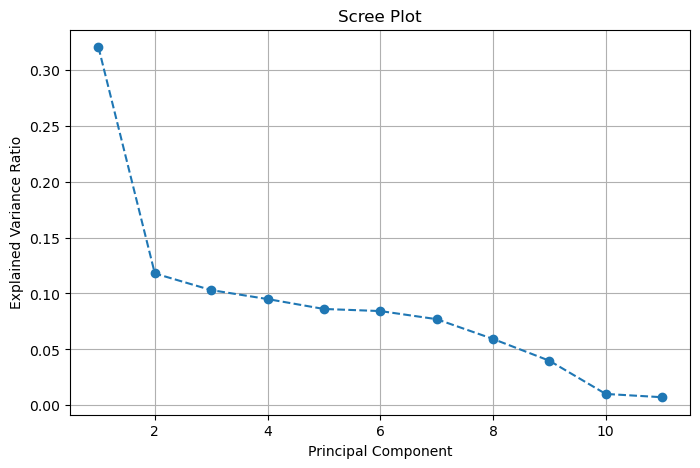

In [26]:
# Create a scree plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

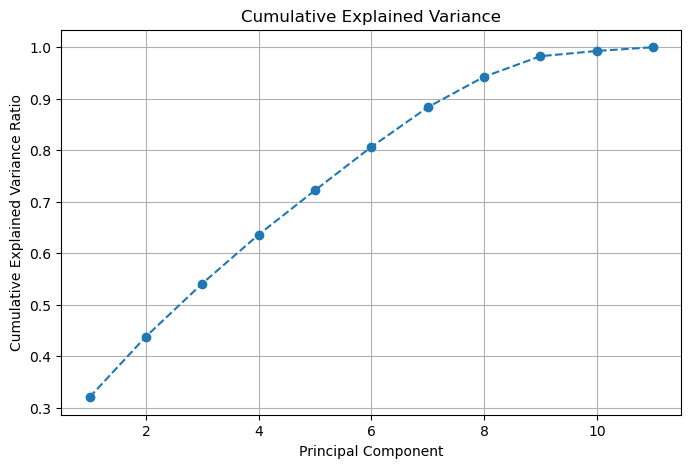

In [27]:
# Create a cumulative variance plot
cumulative_variance = explained_variance_ratio.cumsum()

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

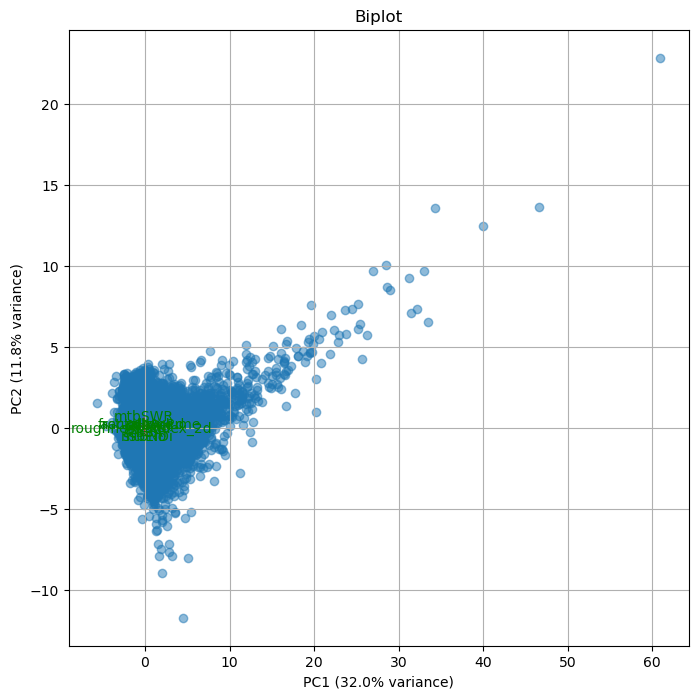

In [28]:
import numpy as np

# Plotting the loadings (biplot)
loadings = pca.components_.T

plt.figure(figsize=(8, 8))
plt.scatter(pca.transform(X_scaled)[:, 0], pca.transform(X_scaled)[:, 1], alpha=0.5)
for i, var in enumerate(variables.columns):
    plt.arrow(0, 0, loadings[i, 0], loadings[i, 1], color='r', alpha=0.5)
    plt.text(loadings[i, 0] * 1.15, loadings[i, 1] * 1.15, var, color='g', ha='center', va='center')
    
plt.xlabel(f"PC1 ({explained_variance_ratio[0]:.1%} variance)")
plt.ylabel(f"PC2 ({explained_variance_ratio[1]:.1%} variance)")
plt.title('Biplot')
plt.grid(True)
plt.show()

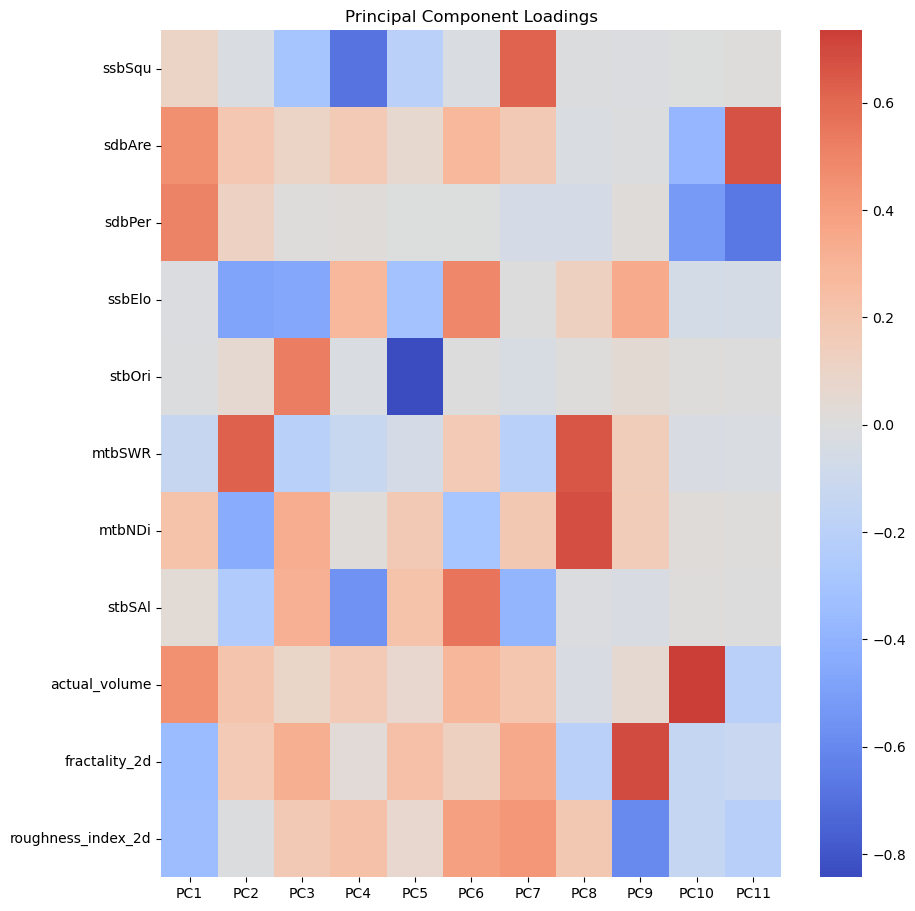

In [29]:
import seaborn as sns

# Convert loadings to DataFrame for better visualization
loadings_df = pd.DataFrame(loadings, columns=[f'PC{i+1}' for i in range(loadings.shape[1])], index=variables.columns)

plt.figure(figsize=(10, 11))
sns.heatmap(loadings_df, annot=False, cmap='coolwarm', center=0)
plt.title('Principal Component Loadings')
plt.show()

In [ ]:
merged